# 🤖 BERT: 개념 + 한국어 실습

## 1️⃣ BERT란 무엇인가요?

**BERT (Bidirectional Encoder Representations from Transformers)**는 2018년 Google AI에서 발표한 강력한 자연어 처리(NLP) 모델입니다.

BERT의 핵심은 **문장을 양방향으로 이해할 수 있다**는 점입니다.

기존 모델(GPT 등)은 한 방향(예: 왼쪽→오른쪽)으로만 문맥을 이해하지만,  
BERT는 **좌우 문맥을 모두 활용**하여 보다 정밀한 언어 이해가 가능합니다.


## 2️⃣ BERT의 구조
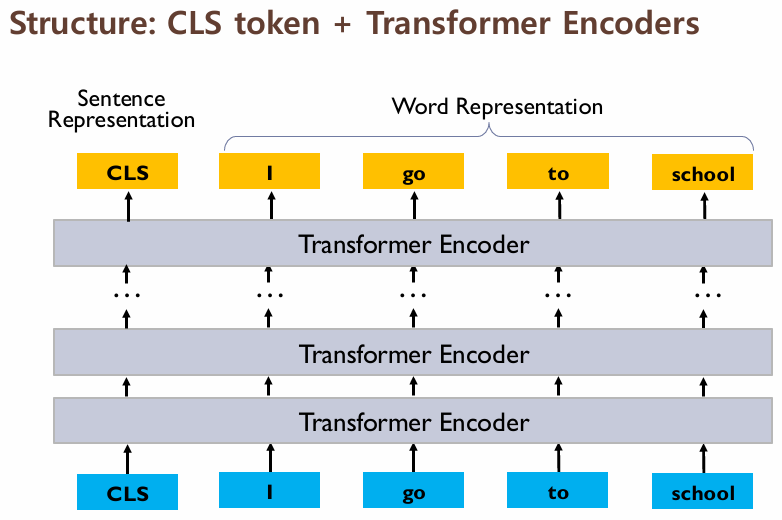

BERT는 Transformer의 **인코더(Encoder)** 구조만 사용합니다.

###  입력 구성 요소
- `[CLS]` 토큰: 문장 분류에 사용
- `[SEP]` 토큰: 문장 구분
- **Token Embedding**: 단어 임베딩
- **Segment Embedding**: 문장 구분 (A/B)
- **Position Embedding**: 순서 정보

BERT-base는 12개의 Transformer Encoder Layer를 가지고 있습니다.


##  BERT Tokenizer란?

Transformer 기반 모델인 BERT는 텍스트를 입력받을 때, 먼저 토큰화(Tokenization)를 수행합니다.  
BERT의 토크나이저는 **WordPiece** 알고리즘을 사용하며, 단어를 더 작은 단위(Subword)로 나누어 처리합니다.

예를 들어:

```
나는 학교에 갑니다 → ['나는', '학교', '에', '갑니다']  
→ WordPiece로는 ['나는', '학', '##교', '##에', '갑', '##니다']
```

BERT의 입력은 다음 3가지 임베딩의 합으로 구성됩니다:
- **Token Embedding**: 토큰 자체의 임베딩
- **Segment Embedding**: 문장 A인지 B인지 구분
- **Position Embedding**: 순서 정보



In [1]:
#  BERT Tokenizer를 사용해 토큰 ID 및 임베딩을 확인해보자
from transformers import BertTokenizer

# BERT multilingual 모델의 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# 예시 문장
sentence = "나는 학교에 갑니다."

# WordPiece 토큰화
tokens = tokenizer.tokenize(sentence)

# 토큰을 ID로 변환
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# 결과 출력
print("Tokens:", tokens)
print("Token IDs:", token_ids)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokens: ['나는', '학', '##교', '##에', '갑', '##니다', '.']
Token IDs: [100585, 9953, 25242, 10530, 8849, 48345, 119]


## 3️⃣ 사전학습 (Pre-training)

BERT는 다음 두 가지 태스크를 통해 사전학습됩니다.

###     (1) Masked Language Modeling (MLM)
문장의 일부 단어를 `[MASK]`로 가리고 예측합니다.

> 예: "나는 [MASK]에 간다." → "학교"





In [2]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

#  1. 모델과 토크나이저 로딩
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)
model.eval()

#  2. 입력 문장: [MASK] 토큰 포함
sentence = "나는 [MASK]에 갑니다."

#  3. 토크나이즈 및 tensor 변환
inputs = tokenizer(sentence, return_tensors="pt")
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

#  4. 모델 예측
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

#  5. 마스킹된 위치의 top 5 예측 단어 출력
mask_logits = logits[0, mask_token_index, :]
topk = torch.topk(mask_logits, k=5, dim=1)

for i in range(5):
    predicted_token_id = topk.indices[0][i].item()
    predicted_token = tokenizer.decode([predicted_token_id])
    score = topk.values[0][i].item()
    print(f"예측 {i+1}: {predicted_token} (score: {score:.4f})")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


예측 1: 여기 (score: 7.4424)
예측 2: 집 (score: 7.1439)
예측 3: 다음 (score: 6.9926)
예측 4: [UNK] (score: 6.6914)
예측 5: 미국 (score: 6.2993)


###  (2) Next Sentence Prediction (NSP)
두 문장이 실제로 이어지는 문장인지 맞추는 이진 분류입니다.

> 문장 A: "나는 밥을 먹었다."<br>문장 B: "그리고 운동을 하러 갔다." → True  
> 문장 B: "비가 내리고 있다." → False

In [3]:
# 필요한 라이브러리 임포트
from transformers import BertTokenizer, BertForNextSentencePrediction
import torch

# 모델 이름 정의 (한국어 BERT 모델 사용)
model_name = "klue/bert-base"

# 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained(model_name)

# NSP(Next Sentence Prediction)용 BERT 모델 로드
model = BertForNextSentencePrediction.from_pretrained(model_name)
model.eval()  # 평가모드 설정

# 예측할 두 개의 문장 정의
sentence_a = "나는 밥을 먹었다."
sentence_b = "비가 내리고 있다."

# 두 문장을 입력 형식으로 변환 (NSP에 맞도록 special tokens 추가됨)
encoding = tokenizer(sentence_a, sentence_b, return_tensors='pt')

# 모델 예측 실행 (labels=[1]: 문장B가 문장A의 다음 문장일 경우)
with torch.no_grad():
    outputs = model(**encoding, labels=torch.LongTensor([1]))
    logits = outputs.logits

# softmax를 통해 확률값 계산
probs = torch.softmax(logits, dim=1)

# 결과 출력
print("이어질 확률 (softmax):", probs)
print(f"→ 예측된 클래스: {'True' if torch.argmax(probs)==1 else 'False'}")

이어질 확률 (softmax): tensor([[0.8889, 0.1111]])
→ 예측된 클래스: False


## 4️⃣ 파인튜닝 (Fine-tuning)

사전학습된 BERT는 다양한 태스크에 쉽게 응용됩니다.

| 태스크 | 설명 | 예시 |
|--------|------|------|
| 문장 분류 | 감정 분석 등 | 긍/부정 |
| 문장 유사도 | 두 문장 의미 비교 | 코사인 유사도 |
| 개체명 인식 | 사람, 장소 등 탐지 | `Apple` → 기관 |
| 질의응답 | 질문에 답 찾기 | SQuAD 데이터셋

모델의 구조를 살짝 수정하고 학습하면 다양한 문제에 적용할 수 있습니다.


## 🇰🇷 한국어용 BERT 모델

한국어에 특화된 다양한 BERT 모델들이 존재합니다:

| 모델명 | 제공기관 | 특징 |
|--------|----------|------|
| KoBERT | SKT | 위키 + 뉴스 기반 |
| KorBERT | ETRI | 대용량 한국어 말뭉치 |
| KLUE-BERT | KLUE | 한국어 벤치마크용 |
| KR-FinBERT | 카카오 | 금융 특화 BERT

Hugging Face에서 쉽게 사용할 수 있습니다.


## 🔄 BERT vs GPT

| 항목 | BERT | GPT |
|------|------|-----|
| 구조 | Transformer Encoder | Transformer Decoder |
| 방향성 | 양방향 | 단방향 (좌→우) |
| 용도 | 이해 중심 | 생성 중심 |
| 태스크 | 분류, NER, QnA 등 | 텍스트 생성, 요약 등 |


###  BERT의 활용 예시

BERT는 다음과 같은 다양한 자연어처리 작업에 활용됩니다:

| Task                     | 설명 |
|--------------------------|------|
| 문장 분류 (Text Classification) | 감정 분석, 뉴스 분류 등 |
| 문장 유사도 (Sentence Similarity) | 두 문장이 얼마나 유사한지 계산 |
| 개체명 인식 (NER) | 문장에서 사람, 장소, 기관 등 추출 |
| 질의응답 (QnA) | 문서를 기반으로 질문에 답변 생성 |

---

BERT는 한국어 전용 모델들도 존재하며, 예를 들어:
- `KoBERT` (SKT 제공)
- `KorBERT` (ETRI 제공)
- `KLUE-BERT` (한국어 벤치마크)

이제 직접 BERT를 활용해보며 그 능력을 체험해봅시다!


## 🎯 감정 분석 (Sentiment Analysis)
한국어 리뷰 문장을 입력하면, 긍정인지 부정인지 판단해주는 예제입니다.

In [4]:
# 필요한 라이브러리 임포트
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch
import torch.nn.functional as F

# 모델 정의 및 설정 (BERT 기반 분류 모델 사용)
model_name = "klue/bert-base"

# 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 긍정/부정(2 클래스)

# pipeline을 이용해 간편히 감성 분석을 수행할 수 있게 설정
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# 예제 문장 정의 (긍정적/부정적 감정을 포함한 문장들)
examples = [
    "이 제품 정말 좋아요!",
    "배송이 느려 화가 났어요.",
    "기대 이상이었어요.",
    "디자인은 별로지만 가격은 좋아요."
]

# 예제 문장들에 대해 분류 수행 및 결과 출력
for text in examples:
    print(f"문장: {text}")
    print("결과:", classifier(text)[0], "\n")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


문장: 이 제품 정말 좋아요!
결과: {'label': 'LABEL_1', 'score': 0.6478144526481628} 

문장: 배송이 느려 화가 났어요.
결과: {'label': 'LABEL_1', 'score': 0.5273078680038452} 

문장: 기대 이상이었어요.
결과: {'label': 'LABEL_1', 'score': 0.6163816452026367} 

문장: 디자인은 별로지만 가격은 좋아요.
결과: {'label': 'LABEL_1', 'score': 0.6613894701004028} 



## 📏 문장 유사도 측정
두 문장이 얼마나 비슷한지를 코사인 유사도를 통해 측정해봅니다.

In [5]:
# 필요한 라이브러리 임포트
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# 모델과 토크나이저 설정 (임베딩을 얻기 위한 기본 BERT 모델 사용)
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# 문장의 embedding을 얻기 위한 함수 정의
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0]  # CLS 토큰의 임베딩을 사용 (문장 전체 의미를 나타냄)

# 유사도를 측정할 문장 쌍 정의
text_pairs = [
    ("나는 학교에 갑니다.", "나는 교육기관으로 향합니다."),  # 의미적으로 유사
    ("오늘 날씨가 참 좋네요.", "대한민국의 수도는 서울입니다."), # 의미적으로 무관
    ("이 영화 진짜 재밌다!", "이 영화는 정말 재미없다.")        # 감정은 반대이지만 주제 유사
]

# 문장 쌍마다 임베딩 생성 후 코사인 유사도 계산 및 출력
for a, b in text_pairs:
    emb1 = get_embedding(a)
    emb2 = get_embedding(b)
    sim = F.cosine_similarity(emb1, emb2).item()
    print(f"문장1: {a}")
    print(f"문장2: {b}")
    print(f"유사도: {sim:.4f}\n")

문장1: 나는 학교에 갑니다.
문장2: 나는 교육기관으로 향합니다.
유사도: 0.8161

문장1: 오늘 날씨가 참 좋네요.
문장2: 대한민국의 수도는 서울입니다.
유사도: 0.5961

문장1: 이 영화 진짜 재밌다!
문장2: 이 영화는 정말 재미없다.
유사도: 0.8059

